<a href="https://colab.research.google.com/github/Kgs-Mathaba/TensorFlow_Development_ZTM/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!nvidia-smi

Mon Oct 25 00:59:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    58W / 149W |   4349MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [89]:
#import helper script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-25 00:59:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-25 00:59:53 (58.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [90]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [91]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-10-25 00:59:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   169MB/s    in 9.3s    

2021-10-25 01:00:02 (166 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [92]:
# ow many images/classes are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/garlic_bread'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fish_and_chips'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pork_chop'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 dire

In [93]:
#Setup data inputs
import tensorflow as tf
IMAGE_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size = IMAGE_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size = IMAGE_SIZE,
                                                                shuffle=False) # for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big dog model with transfer learning on 10% of 101 food classes

In [94]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)


In [95]:
# Create a data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomWidth(0.2),
  #preprocessing.Rescalling(1/255.) # efficientNetBo already has scaling layer
], name="data_augmentation")

In [96]:
# Setup base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layer
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_poll_layer")(x)
output = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
# Build model
model = tf.keras.Model(inputs, output)

In [97]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_poll_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [98]:
# Compile model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'],
              )

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 70s 261ms/step - loss: 3.4777 - accuracy: 0.2437 - val_loss: 2.7659 - val_accuracy: 0.3750
Epoch 2/5
237/237 [==============================] - 60s 253ms/step - loss: 2.3543 - accuracy: 0.4591 - val_loss: 2.2839 - val_accuracy: 0.4558
Epoch 3/5
237/237 [==============================] - 61s 255ms/step - loss: 1.9801 - accuracy: 0.5259 - val_loss: 2.1092 - val_accuracy: 0.4801
Epoch 4/5
237/237 [==============================] - 59s 245ms/step - loss: 1.7612 - accuracy: 0.5752 - val_loss: 2.0143 - val_accuracy: 0.4905
Epoch 5/5
237/237 [==============================] - 60s 252ms/step - loss: 1.6013 - accuracy: 0.6086 - val_loss: 1.9635 - val_accuracy: 0.4931


In [99]:
# Evaluate on the whole test set
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 101s 128ms/step - loss: 1.7262 - accuracy: 0.5508


[1.7262368202209473, 0.5507722496986389]

In [100]:
feature_extraction_results = fine_tune_results

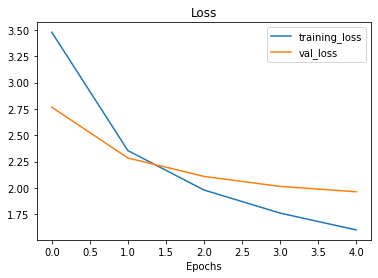

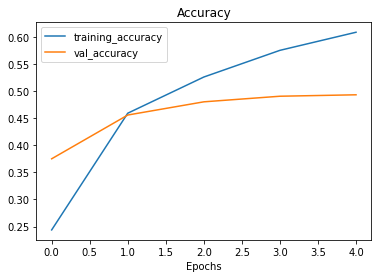

In [101]:
plot_loss_curves(history_all_classes_10_percent)

# Fine tuning the model

In [102]:
# Unfreeze some of the layer in the base model
base_model.trainable = True

# Refreeze every layers except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [103]:
# Recompile the model with lower learning reate now that some of the base model layer are trainable
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [104]:
# What layers are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_poll_layer True
output_layer True


In [105]:
#check which layers are rainable in base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)
  

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [106]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10

# Fine tune model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])


Epoch 5/10
237/237 [==============================] - 67s 249ms/step - loss: 1.3724 - accuracy: 0.6422 - val_loss: 1.9560 - val_accuracy: 0.4934
Epoch 6/10
237/237 [==============================] - 57s 239ms/step - loss: 1.2298 - accuracy: 0.6776 - val_loss: 1.9551 - val_accuracy: 0.4952
Epoch 7/10
237/237 [==============================] - 57s 238ms/step - loss: 1.1583 - accuracy: 0.6911 - val_loss: 1.8984 - val_accuracy: 0.5079
Epoch 8/10
237/237 [==============================] - 57s 239ms/step - loss: 1.0678 - accuracy: 0.7174 - val_loss: 1.9153 - val_accuracy: 0.5069
Epoch 9/10
237/237 [==============================] - 57s 237ms/step - loss: 1.0191 - accuracy: 0.7258 - val_loss: 1.9668 - val_accuracy: 0.5032
Epoch 10/10
237/237 [==============================] - 54s 227ms/step - loss: 0.9627 - accuracy: 0.7464 - val_loss: 1.8880 - val_accuracy: 0.5132


In [107]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 101s 128ms/step - loss: 1.5978 - accuracy: 0.5796


[1.597824215888977, 0.5796435475349426]

In [108]:
feature_extraction_results

[1.7262368202209473, 0.5507722496986389]

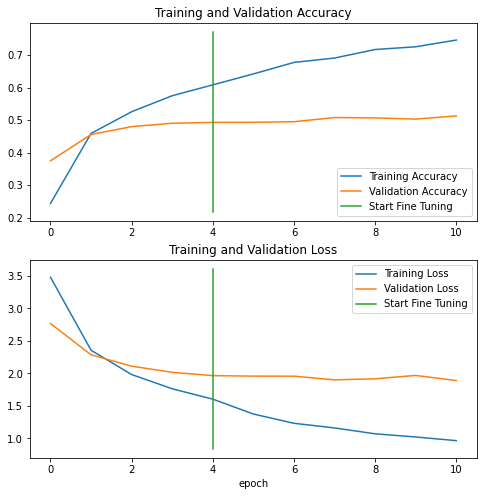

In [109]:
# compare histories
compare_historys(original_history=history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

In [110]:
## Save the fine tuned model
#model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")


In [111]:
# Load saved model
#loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [112]:
# check perfomance of loaded model
#loaded_model_results = loaded_model.evaluate(test_data)
#loaded_model_results

In [113]:
# Compare with unsaved model
all_classes_10_percent_fine_tune_results

[1.597824215888977, 0.5796435475349426]

In [114]:
#download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-10-25 01:19:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.128, 108.177.120.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M   157MB/s    in 0.3s    

2021-10-25 01:19:43 (157 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [115]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [116]:
model_1 = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [118]:
results_downloaded_model = model_1.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 103s 130ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

In [119]:
# Make prediction with the model
pred_probs = model_1.predict(test_data, verbose=1)

790/790 [==============================] - 88s 110ms/step


In [120]:
len(pred_probs)

25250

In [121]:
# shape of predictions
pred_probs.shape

(25250, 101)

In [122]:
# first 10 prediction
pred_probs[:10]

array([[5.9541941e-02, 3.5742332e-06, 4.1376889e-02, ..., 1.4138899e-09,
        8.3530460e-05, 3.0897565e-03],
       [9.6401680e-01, 1.3753089e-09, 8.4779976e-04, ..., 5.4286684e-05,
        7.8363253e-12, 9.8467334e-10],
       [9.5925868e-01, 3.2534019e-05, 1.4867033e-03, ..., 7.1891884e-07,
        5.4398350e-07, 4.0276311e-05],
       ...,
       [4.7313324e-01, 1.2931301e-07, 1.4805583e-03, ..., 5.9749611e-04,
        6.6969820e-05, 2.3469329e-05],
       [4.4571780e-02, 4.7265351e-07, 1.2258515e-01, ..., 6.3498578e-06,
        7.5319103e-06, 3.6778715e-03],
       [7.2438985e-01, 1.9249777e-09, 5.2310857e-05, ..., 1.2291447e-03,
        1.5793171e-09, 9.6395503e-05]], dtype=float32)

In [123]:
pred_probs[:1]

array([[5.9541941e-02, 3.5742332e-06, 4.1376889e-02, 1.0660903e-09,
        8.1613996e-09, 8.6639682e-09, 8.0926134e-07, 8.5652442e-07,
        1.9858850e-05, 8.0977554e-07, 3.1727692e-09, 9.8673388e-07,
        2.8532100e-04, 7.8049661e-10, 7.4230990e-04, 3.8915794e-05,
        6.4740016e-06, 2.4977169e-06, 3.7891397e-05, 2.0678806e-07,
        1.5538471e-05, 8.1506892e-07, 2.6230925e-06, 2.0010653e-07,
        8.3827712e-07, 5.4215743e-06, 3.7391112e-06, 1.3150788e-08,
        2.7761345e-03, 2.8051816e-05, 6.8561651e-10, 2.5574524e-05,
        1.6688934e-04, 7.6409645e-10, 4.0452869e-04, 1.3150487e-08,
        1.7957433e-06, 1.4448400e-06, 2.3062853e-02, 8.2465459e-07,
        8.5366531e-07, 1.7138503e-06, 7.0526130e-06, 1.8402382e-08,
        2.8553984e-07, 7.9482870e-06, 2.0682012e-06, 1.8525193e-07,
        3.3619781e-08, 3.1522335e-04, 1.0410886e-05, 8.5448306e-07,
        8.4741890e-01, 1.0555387e-05, 4.4094719e-07, 3.7404192e-05,
        3.5306137e-05, 3.2489079e-05, 6.7313988e

In [124]:
pred_probs[:1].shape

(1, 101)

In [125]:
print(f'Number of prediction probabilities for sample 0 = :{len(pred_probs[0])}')
print(f'What prediction probability sample 0 looks like:\n {pred_probs[0]}')
print(f'The class with the highest predicted probability by the model for sample 0 is: {pred_probs[81].argmax()}')

Number of prediction probabilities for sample 0 = :101
What prediction probability sample 0 looks like:
 [5.9541941e-02 3.5742332e-06 4.1376889e-02 1.0660903e-09 8.1613996e-09
 8.6639682e-09 8.0926134e-07 8.5652442e-07 1.9858850e-05 8.0977554e-07
 3.1727692e-09 9.8673388e-07 2.8532100e-04 7.8049661e-10 7.4230990e-04
 3.8915794e-05 6.4740016e-06 2.4977169e-06 3.7891397e-05 2.0678806e-07
 1.5538471e-05 8.1506892e-07 2.6230925e-06 2.0010653e-07 8.3827712e-07
 5.4215743e-06 3.7391112e-06 1.3150788e-08 2.7761345e-03 2.8051816e-05
 6.8561651e-10 2.5574524e-05 1.6688934e-04 7.6409645e-10 4.0452869e-04
 1.3150487e-08 1.7957433e-06 1.4448400e-06 2.3062853e-02 8.2465459e-07
 8.5366531e-07 1.7138503e-06 7.0526130e-06 1.8402382e-08 2.8553984e-07
 7.9482870e-06 2.0682012e-06 1.8525193e-07 3.3619781e-08 3.1522335e-04
 1.0410886e-05 8.5448306e-07 8.4741890e-01 1.0555387e-05 4.4094719e-07
 3.7404192e-05 3.5306137e-05 3.2489079e-05 6.7313988e-05 1.2852399e-08
 2.6220215e-10 1.0318094e-05 8.5742751e-05 

In [126]:
test_data.class_names[0]

'apple_pie'

In [127]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [128]:
# Need to unbatch the test_data to get the test labels
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [129]:
y_labels = []
for image, label in test_data.unbatch():
  y_labels.append(label.numpy().argmax())

y_labels[:10] # look at the first 10 and compare with pred_classes

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [130]:
len(y_labels)

25250

In [131]:
# Use sckikit-learn's accuracy score
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)
sklearn_accuracy

0.6077623762376237

In [132]:
# get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [133]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  #changed ( need to plot x label vertically)
  plt.xticks(rotation=70, fontsize = text_size)


  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)


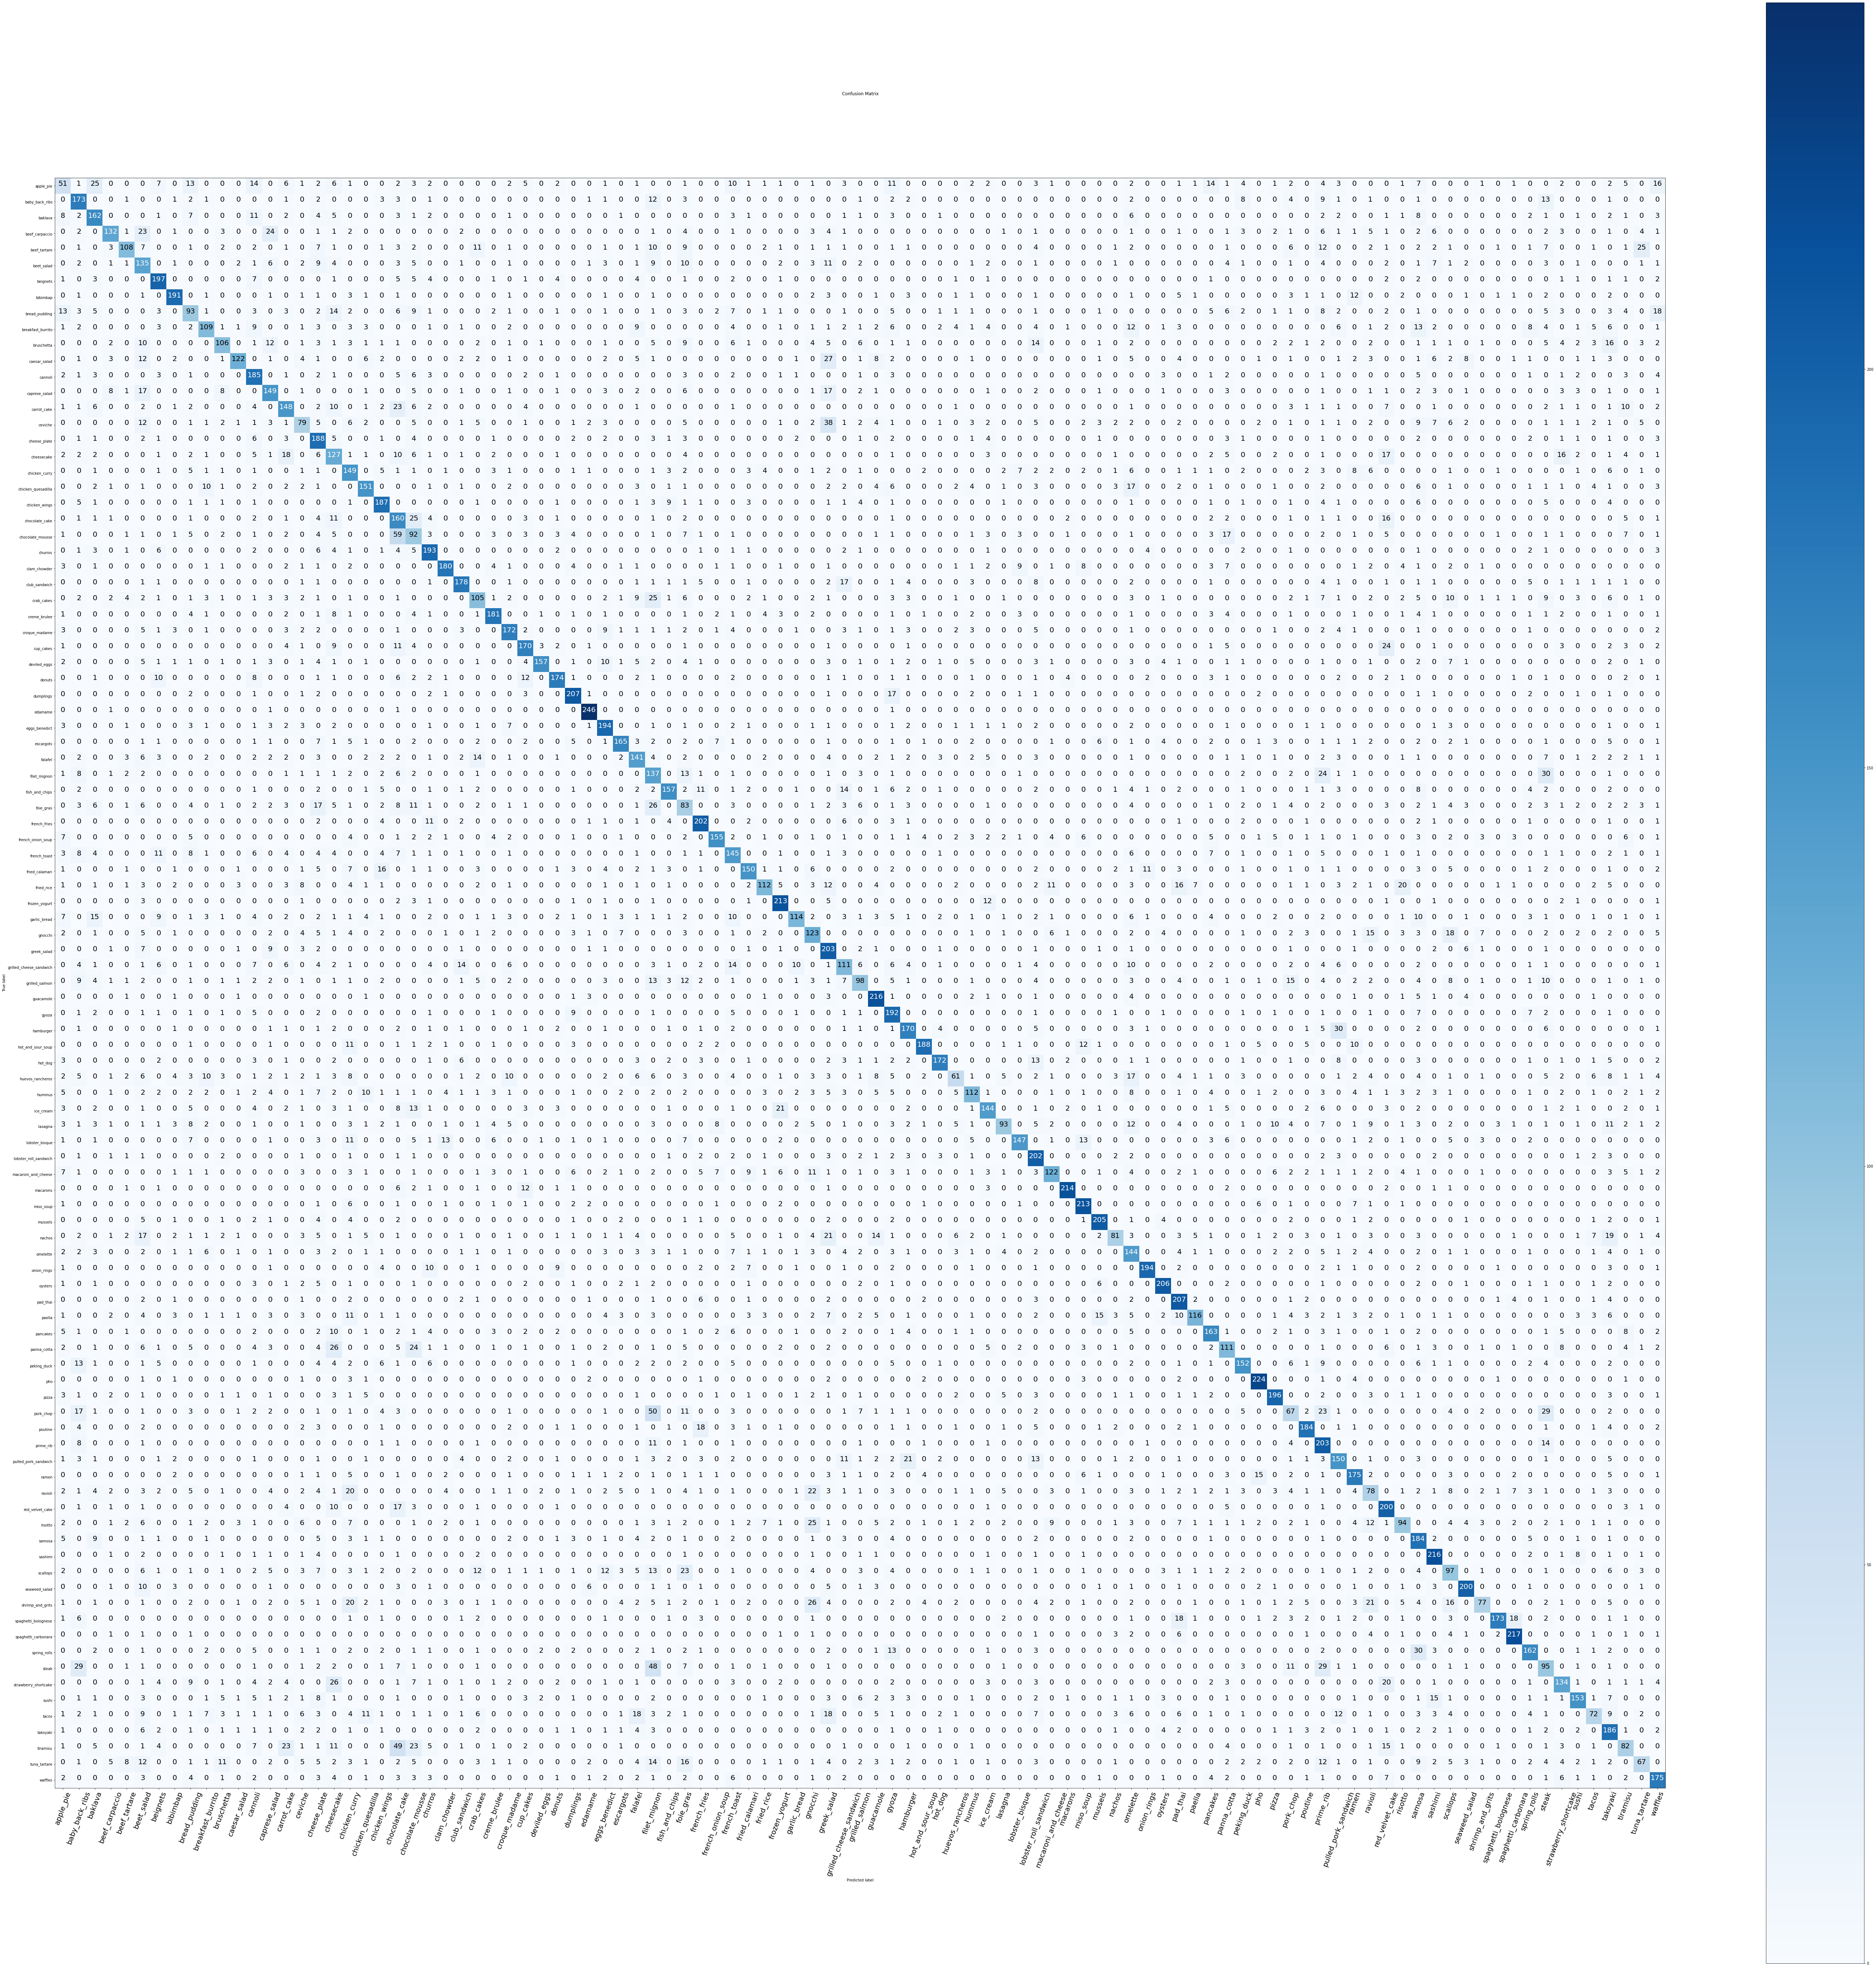

In [134]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True,)

In [135]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [136]:
# create a dictionary of classification report
classification_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [137]:
class_names[75]

'pho'

In [138]:
classification_dict["75"]

{'f1-score': 0.8665377176015473,
 'precision': 0.8389513108614233,
 'recall': 0.896,
 'support': 250}

In [139]:
class_f1_score = {}
for k, v in classification_dict.items():
  if k =='accuracy': # stop once we get to accuracy key
    break
  else:
    # Add class names and f1 scores to new dict
    class_f1_score[class_names[int(k)]] = v['f1-score']

class_f1_score

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [140]:
# Tuen f1-score into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_score.keys()),
                         "f1-score":list(class_f1_score.values())}).sort_values("f1-score", ascending=False)

In [141]:
f1_scores[:10]

,class_name,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
68,onion_rings,0.832618
65,mussels,0.820000
88,seaweed_salad,0.813008
64,miso_soup,0.812977
45,frozen_yogurt,0.811429


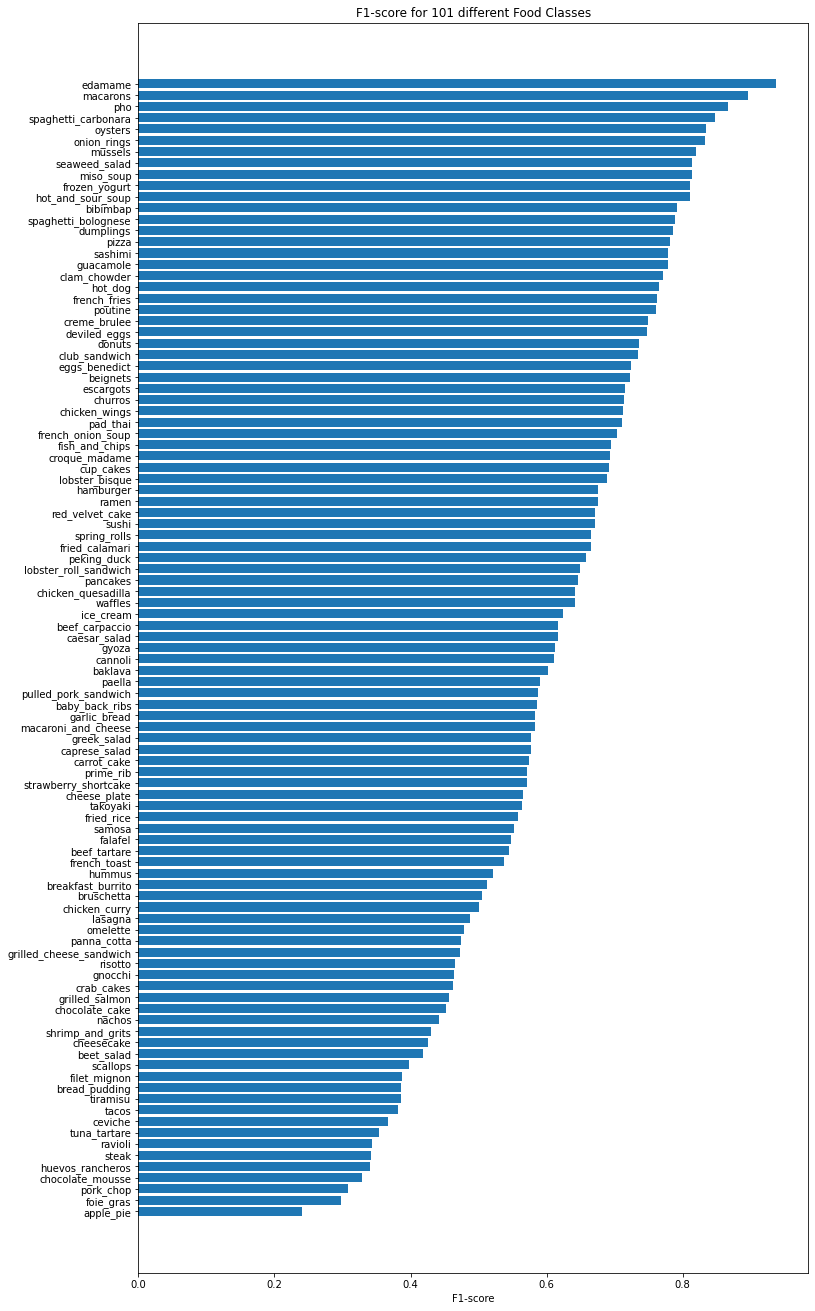

In [142]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,23))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_name'])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 different Food Classes")
ax.invert_yaxis();

## Visualizing predictions on test images

In [143]:
# Create function to laod and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, channels=3)

  Args:
  filename (str): path to target image
  image_shape (int): height/width dimension of target image size
  scale (bool): scale pixel values from0-255 to 0-1 or not

  Returns:
    Images tensor of shape(img_shape, img_shape)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale Yess/no
  if scale:
    # rescale image
    return img/255.
  else:
    return img

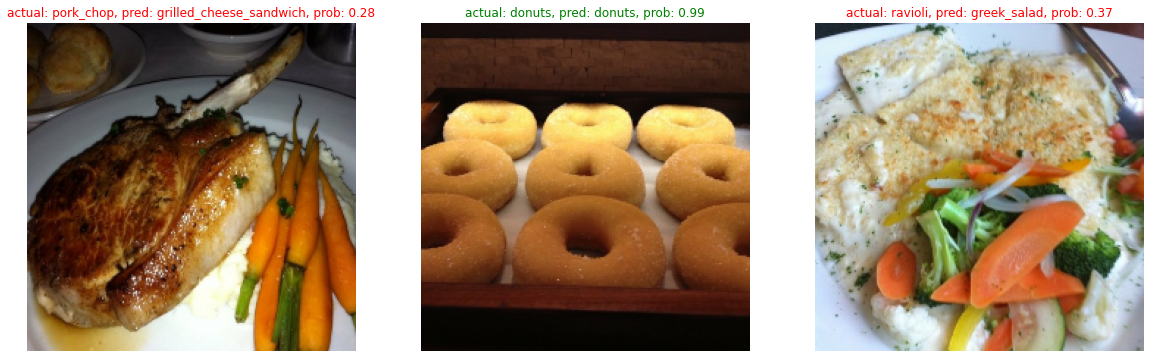

In [168]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(20, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);